###Deep Recommender: Neural Colaborative Filtering

In this tutorial, we demostrate how a basic matrix factorization algorithm can be replicated using a neural network. We next extend this basic network to incorporate item features (embeddings) extracted using a pre-trained NLP model.

### DATA

In [2]:
import os
import numpy as np
import pandas as pd
import random
import warnings
from tabulate import tabulate

import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Dense, Dot, Flatten, Concatenate, Add
from sklearn.model_selection import train_test_split

In [3]:
!pip install sentence-transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 1.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 14.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 28.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 23.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 30.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 24.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 9.5 MB/s eta 0:00:00
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125923 sha256=537609e3efbc5ddcde61dd40ebada85bd47f804b12432f8999f7f8d5c6be2b41
  Stored in directory: /root/.cache/pip/wheels/62/f2/10/1e606fd5f02395388f74e7462910fe851042f97238cbbd902f
Successfully built sentence-transformers


In [5]:
import tensorflow as tf
from sentence_transformers import SentenceTransformer
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams.update({'pdf.fonttype': 'truetype'})
warnings.simplefilter("ignore")

print("Tensorflow version " + tf.__version__)

Tensorflow version 2.13.0


In [6]:
#
# Helper functions
#
def print_df(df, col_width = 10, rows = 10, max_cols = 10):
    def short_srt(x):
        return x if len(x) < col_width else x[:col_width-3] + "..."
    df_short = df.head(rows).applymap(lambda x: short_srt(str(x)))

    if len(df_short.columns) > max_cols:
        df_short = df_short.iloc[:, 0:max_cols-1]
        df_short['...'] = '...'

    print(tabulate(df_short, headers='keys', tablefmt='psql'))
    print(f'{len(df)} rows x {len(df.columns)} columns')

def plot_keras_training_hitory(history):
    plt.plot(history.history['loss']);
    plt.plot(history.history['val_loss']);
    plt.xlabel('Training epoch')
    plt.ylabel('Loss')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.grid(True)

Load Data

In [12]:
from google.colab import drive
import io
import pandas as pd

# Mount Google Drive
drive.mount('/content/drive')

# Specify the folder name
folder_name = 'ADM_Presentation'

# Define the file names
movies_csv_filename = 'movies.csv'
ratings_csv_filename = 'ratings.csv'
tags_csv_filename = 'tags.csv'

# Construct the full paths to the CSV files
movies_csv_path = f'/content/drive/My Drive/{folder_name}/{movies_csv_filename}'
ratings_csv_path = f'/content/drive/My Drive/{folder_name}/{ratings_csv_filename}'
tags_csv_path = f'/content/drive/My Drive/{folder_name}/{tags_csv_filename}'

# Read the uploaded CSV files
items = pd.read_csv(movies_csv_path, sep=',', skiprows=1, names=['item_id', 'title', 'genres'])
ratings = pd.read_csv(ratings_csv_path, sep=',', skiprows=1, names=['user_id', 'item_id', 'rating', 'timestamp'])
tags = pd.read_csv(tags_csv_path, sep=',', skiprows=1, names=['user_id', 'item_id', 'tag', 'timestamp'])

# Rest of your code remains the same.
# You can continue with the rest of your data processing logic.

#
# Concatenate tags
#
tags_flat = tags[['item_id', 'tag']]\
    .groupby(by=['item_id'])['tag']\
    .apply(list)\
    .apply(lambda x: ' '.join(list(map(str, x))))\
    .apply(str.lower)
items = items.join(tags_flat, on='item_id')

#
# Preprocessing
#

# Remove movies with short tag lines
items = items[items['tag'].str.len() > 200]
ratings = ratings[ratings['item_id'].isin(items['item_id'].unique())]
# Remove users with less than 50 ratings
ratings = ratings[ratings.groupby(by='user_id')['user_id'].transform('size') > 50]
ratings['rating'] = ratings['rating'].round(0).astype(int)

# Remap user and item IDs to sequential integers
n_users, n_items = ratings['user_id'].nunique(), ratings['item_id'].nunique()
item_id_lookup = { old_id:new_id for (old_id, new_id) in zip(items['item_id'].values, np.arange(n_items)) }
items['item_id'] = items['item_id'].apply(lambda x: item_id_lookup[x])
ratings['item_id'] = ratings['item_id'].apply(lambda x: item_id_lookup[x])

user_id_lookup = { old_id:new_id for (old_id, new_id) in zip(ratings['user_id'].unique(), np.arange(n_users)) }
ratings['user_id'] = ratings['user_id'].apply(lambda x: user_id_lookup[x])

print_df(items, col_width = 30)
print_df(ratings)

#
# Calculate statistics and limits
#
user_ids, item_ids = ratings['user_id'].unique(), ratings['item_id'].unique()
max_user_id, max_item_id = max(ratings['user_id']), max(ratings['item_id'])
print(f'Max user id: {max_user_id}, max item id: {max_item_id}')

Mounted at /content/drive
+----+-----------+--------------------------------+--------------------------------+--------------------------------+
|    |   item_id | title                          | genres                         | tag                            |
|----+-----------+--------------------------------+--------------------------------+--------------------------------|
|  0 |         0 | Toy Story (1995)               | Adventure|Animation|Childre... | watched computer animation ... |
|  1 |         1 | Jumanji (1995)                 | Adventure|Children|Fantasy     | time travel adapted from:bo... |
|  2 |         2 | Grumpier Old Men (1995)        | Comedy|Romance                 | old people that is actually... |
|  4 |         3 | Father of the Bride Part II... | Comedy                         | diane keaton family sequel ... |
|  5 |         4 | Heat (1995)                    | Action|Crime|Thriller          | realistic action al pacino ... |
|  6 |         5 | Sabrina (19

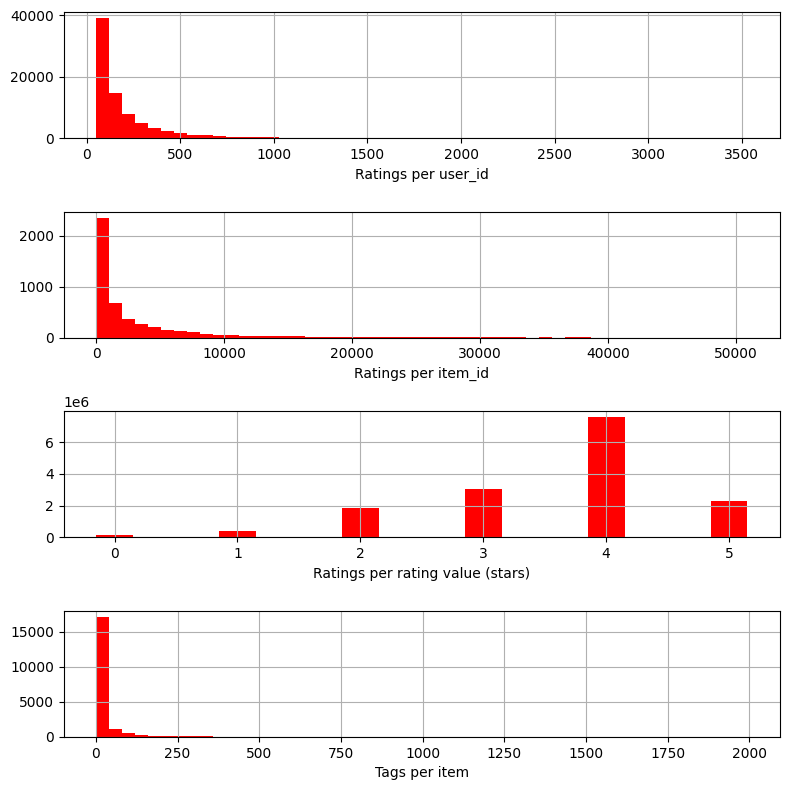

In [13]:
#
# Visualize the main statistics
#
fig, ax = plt.subplots(4, 1, figsize=(8, 8) )
for i, c in enumerate(['user_id', 'item_id']):
    sns.distplot(ratings.groupby(by=[c]).count().iloc[:, 0].values, kde=False, ax=ax[i],
                 axlabel=f'Ratings per {c}', color='red', hist_kws=dict(alpha=1))
    ax[i].grid(True)

rating_frequencies = ratings.groupby(by=['rating']).count().iloc[:, 0]
ax[2].bar(rating_frequencies.index, rating_frequencies, color='red', width=.3)
ax[2].grid(True)
ax[2].set_xlabel('Ratings per rating value (stars)')
plt.tight_layout()

tag_frequencies = tags.groupby(by=['item_id']).count().iloc[:, 0].values
sns.distplot(tag_frequencies, kde=False, ax=ax[3],
                 axlabel=f'Tags per item', color='red', hist_kws=dict(alpha=1))
ax[3].grid(True)
plt.tight_layout()

In [14]:

# Fix the train-test split
#
n = ratings.shape[0]
train_idx, test_idx, _, _ = train_test_split(np.arange(n), np.arange(n), test_size=0.20, random_state=42)

### Model 1: Neural Collaborative Filtering (Factorization Network)

In this section, we train and evaluate a basic network that replicates the standard matrix factorization algorithm.

Epoch 1/4
12260/12260 [==============================] - 244s 20ms/step - loss: 13.8913 - root_mean_squared_error: 3.7269 - val_loss: 13.8425 - val_root_mean_squared_error: 3.7206
Epoch 2/4
12260/12260 [==============================] - 230s 19ms/step - loss: 13.8037 - root_mean_squared_error: 3.7152 - val_loss: 13.7550 - val_root_mean_squared_error: 3.7089
Epoch 3/4
12260/12260 [==============================] - 243s 20ms/step - loss: 13.7164 - root_mean_squared_error: 3.7034 - val_loss: 13.6679 - val_root_mean_squared_error: 3.6971
Epoch 4/4
12260/12260 [==============================] - 231s 19ms/step - loss: 13.6293 - root_mean_squared_error: 3.6916 - val_loss: 13.5810 - val_root_mean_squared_error: 3.6853


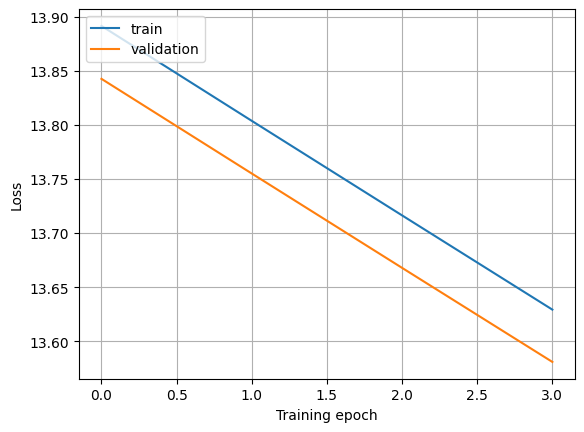

In [19]:
x_train, x_test = ratings[['user_id', 'item_id']].values[train_idx], ratings[['user_id', 'item_id']].values[test_idx]
y_train, y_test = ratings['rating'].values[train_idx], ratings['rating'].values[test_idx]

#
# Model specification
#
embedding_dim = 8

input_user = Input(shape=(1,))
input_item = Input(shape=(1,))

embedding_user = Embedding(input_dim=max_user_id + 1, output_dim=embedding_dim)(input_user)
embedding_item = Embedding(input_dim=max_item_id + 1, output_dim=embedding_dim)(input_item)

combined = Dot(axes=2)([embedding_user, embedding_item])

score = Dense(1, activation='linear')(combined)

model_sgd = Model(inputs=[input_user, input_item], outputs=score)

#
# Model training
#
opt = tf.keras.optimizers.Adam(learning_rate=0.000001)
model_sgd.compile(optimizer=opt, loss='mse', metrics=[tf.keras.metrics.RootMeanSquaredError()])
history_sgd = model_sgd.fit([x_train[:, 0], x_train[:, 1]], y_train,
                    batch_size=1000, epochs=4, verbose=1,
                    validation_data=([x_test[:, 0], x_test[:, 1]], y_test))

plot_keras_training_hitory(history_sgd)

95778/95778 [==============================] - 213s 2ms/step


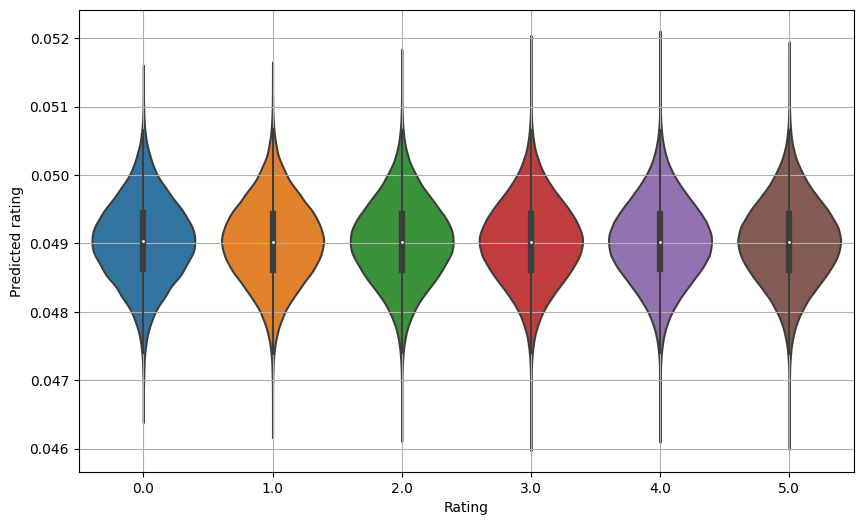

In [20]:
y_test_hat = model_sgd.predict([x_test[:, 0], x_test[:, 1]])[:, 0, 0]
plot_data = pd.DataFrame(np.vstack([y_test, y_test_hat]).T, columns=['Rating', 'Predicted rating'])
fig, ax = plt.subplots(1, figsize=(10, 6))
sns.violinplot(data=plot_data, x = "Rating", y = "Predicted rating", ax=ax)
plt.grid(True)

In [21]:
def get_items(user_id):
    u_items = ratings[ratings['user_id'] == user_id].merge(items, on='item_id', how='left')
    return u_items[['title', 'rating']].sort_values(by=['rating'], ascending=False)

def recommend_for_user(model, user_id, k):
    x1, x2 = np.repeat(user_id, n_items), item_ids
    ratings = model.predict([x1, x2]).ravel()
    top_k_indexes = ratings.argsort()[-k:][::-1]
    return x2[top_k_indexes], ratings[top_k_indexes]

def show_recommendations(r_items, r_ratings):
    r = pd.DataFrame(data=np.vstack([r_items, r_ratings]).T, columns=['item_id', 'rating'])
    print_df(r.merge(items, on='item_id', how='left')[['title', 'rating']], col_width = 50)

#
# Generate recommendations for an example user
#
user_id = 0
k_recomendations = 10
print_df(get_items(user_id), col_width = 50, rows = 10)
r_items, r_ratings = recommend_for_user(model_sgd, user_id, k_recomendations)
show_recommendations(r_items, r_ratings)

+-----+----------------------------------------------------+----------+
|     | title                                              |   rating |
|-----+----------------------------------------------------+----------|
| 121 | Lord of the Rings: The Fellowship of the Ring, ... |        5 |
| 155 | Freaks (1932)                                      |        5 |
| 131 | Lord of the Rings: The Two Towers, The (2002)      |        5 |
| 145 | Lord of the Rings: The Return of the King, The ... |        5 |
|   0 | Jumanji (1995)                                     |        4 |
| 106 | O Brother, Where Art Thou? (2000)                  |        4 |
| 100 | Hook (1991)                                        |        4 |
| 101 | Misery (1990)                                      |        4 |
| 103 | Crouching Tiger, Hidden Dragon (Wo hu cang long... |        4 |
| 104 | Dungeons & Dragons (2000)                          |        4 |
+-----+----------------------------------------------------+----

### Model 2: Network with Item Features
In this section, we build a simple extension of the basic neural collaborative filtering network to incroporate embeddigns produced based movie tags.

We create item embeddigns by concatenating all movie tags into pseudo-sentence and encoding it using a pre-trained MiniLM model.

In [ ]:
text_model = SentenceTransformer('all-MiniLM-L6-v2')
items['item_features'] = items['tag'].transform(text_model.encode)

item_features_r = ratings.merge(items[['item_id', 'item_features']], on='item_id')['item_features']
item_features_r = np.vstack(item_features_r)
print(f'Item features shape: {item_features_r.shape}')
feature_dim = item_features_r.shape[1]

x1_train, x2_train, x3_train = ratings['user_id'].values[train_idx], ratings['item_id'].values[train_idx], item_features_r[train_idx]
x1_test, x2_test, x3_test = ratings['user_id'].values[test_idx], ratings['item_id'].values[test_idx], item_features_r[test_idx]
y_train, y_test = ratings['rating'].values[train_idx], ratings['rating'].values[test_idx]

del item_features_r

In [25]:
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Add
from tensorflow.keras.layers import Dot
from tensorflow.keras.models import Model

import tensorflow as tf

In [12]:
import numpy as np

# Create a NumPy array (replace this with your actual data)
data = np.array([[1, 2, 3], [4, 5, 6]])

# Check the number of dimensions and the shape
num_dimensions = data.ndim
shape = data.shape

print("Number of dimensions:", num_dimensions)
print("Shape of the array:", shape)

Number of dimensions: 2
Shape of the array: (2, 3)


In [13]:
# Sample dataset (replace this with your actual data)
user_ids = [1, 2, 3, 4, 5]

# Calculate the maximum user ID
max_user_id = max(user_ids)

In [2]:
data = {
    'title': [
        "Lord of the Rings: The Fellowship of the Ring, The (2001)",
        "Freaks (1932)"
    ],
    'rating': [5, 5]
}

df = pd.DataFrame(data)

# Save the DataFrame to a CSV file
df.to_csv('your_saved_data.csv', index=False)

In [14]:
# Sample dataset (replace this with your actual data)
item_ids = [101, 102, 103, 104, 105]

# Calculate the maximum item ID
max_item_id = max(item_ids)

In [6]:
feature_dim = 2

In [3]:
def model_hybrid(embedding_dim):
    input_user = Input(shape=(1,))
    input_item = Input(shape=(1,))
    input_item_e = Input(shape=(feature_dim,))

    embedding_user = Embedding(input_dim=max_user_id + 1, output_dim=embedding_dim)(input_user)
    embedding_item = Embedding(input_dim=max_item_id + 1, output_dim=embedding_dim)(input_item)

    #e1 = Flatten()(embedding_user)
    #e2 = Flatten()(embedding_item)
    e1 = embedding_user
    e2 = embedding_item

    t = Dense(embedding_dim, activation='relu')(input_item_e)
    e2 = Add()([e2, t])
    #e2 = Dense(embedding_dim, activation='relu')(e2)

    combined = Dot(axes=2)([e1, e2])
    rating = Dense(1, activation='linear')(combined)

    model = Model(inputs=[input_user, input_item, input_item_e], outputs=rating)

    return model

In [4]:
def recommend_for_user_hybrid(model, user_id, k):
    x1, x2, x3 = np.repeat(user_id, n_items), item_ids, np.vstack(items['item_features'].values)
    ratings = model.predict([x1, x2, x3]).ravel()
    top_k_indexes = ratings.argsort()[-k:][::-1]
    return x2[top_k_indexes], ratings[top_k_indexes]

#
# Generate recommendations for an example user
#
user_id = 0
k_recomendations = 10
print(df)

                                               title  rating
0  Lord of the Rings: The Fellowship of the Ring,...       5
1                                      Freaks (1932)       5
